## Restricted Boltzmann Machine (RBM) — MNIST Dimensionality Reduction

#### Import Libraries & Setup

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tf.random.set_seed(42)
np.random.seed(42)

Importing required libraries for RBM model creation, dataset loading, and visualizations.

Setting seeds to maintain reproducibility.

### Load MNIST Dataset

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train.astype('float32') / 255.).reshape(-1, 784)
x_test  = (x_test.astype('float32') / 255.).reshape(-1, 784)

print("Training data:", x_train.shape)
print("Testing data:", x_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 19s 2us/step
Training data: (60000, 784)
Testing data: (10000, 784)


MNIST has 28×28 = 784 pixels → Flattened into a vector of size 784.

Pixel values normalized to [0,1] for Bernoulli visible units.

### Define RBM Model

In [11]:
class RBM:
    def __init__(self, n_visible=784, n_hidden=128, lr=0.05, momentum=0.5, wd=1e-4):

        self.W  = tf.Variable(tf.random.normal([n_visible, n_hidden], stddev=0.01))
        self.bv = tf.Variable(tf.zeros([n_visible]))
        self.bh = tf.Variable(tf.zeros([n_hidden]))

        self.lr = lr
        self.momentum = momentum
        self.wd = wd

        self.W_vel  = tf.Variable(tf.zeros_like(self.W))
        self.bv_vel = tf.Variable(tf.zeros_like(self.bv))
        self.bh_vel = tf.Variable(tf.zeros_like(self.bh))

    def propup(self, v):
        return tf.sigmoid(tf.matmul(v, self.W) + self.bh)

    def propdown(self, h):
        return tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.bv)

    def sample(self, probs):
        return tf.cast(tf.random.uniform(tf.shape(probs)) < probs, tf.float32)

    def cd1(self, v0):
        ph0 = self.propup(v0)
        h0  = self.sample(ph0)

        pv1 = self.propdown(h0)
        ph1 = self.propup(pv1)

        pos = tf.matmul(tf.transpose(v0), ph0)
        neg = tf.matmul(tf.transpose(pv1), ph1)

        batch = tf.cast(tf.shape(v0)[0], tf.float32)

        dW  = (pos - neg) / batch - self.wd * self.W
        dbv = tf.reduce_mean(v0 - pv1, axis=0)
        dbh = tf.reduce_mean(ph0 - ph1, axis=0)

        self.W_vel.assign(self.momentum * self.W_vel + self.lr * dW)
        self.bv_vel.assign(self.momentum * self.bv_vel + self.lr * dbv)
        self.bh_vel.assign(self.momentum * self.bh_vel + self.lr * dbh)

        self.W.assign_add(self.W_vel)
        self.bv.assign_add(self.bv_vel)
        self.bh.assign_add(self.bh_vel)

        return pv1

    def hidden_rep(self, v):
        return self.propup(v)


Visible Layer = 784 → flattened MNIST pixels

Hidden Layer = 128 latent features

Uses:

Sigmoid units

Weight matrix + visible/hidden biases

Momentum and weight decay for smoother learning

### Train RBM with CD-1

In [15]:
rbm = RBM(n_visible=784, n_hidden=128)

batch_size = 64
epochs = 20
batches = int(x_train.shape[0] / batch_size)

loss_curve = []

for epoch in range(epochs):
    idx = np.random.permutation(len(x_train))
    x = x_train[idx]

    mse = 0
    for i in range(batches):
        batch = tf.convert_to_tensor(x[i*batch_size:(i+1)*batch_size], dtype=tf.float32)
        reconstruction = rbm.cd1(batch)
        mse += tf.reduce_mean(tf.square(batch - reconstruction))

    mse /= batches
    loss_curve.append(mse.numpy())
    print(f"Epoch {epoch+1}: Reconstruction MSE = {mse:.6f}")


Epoch 1: Reconstruction MSE = 0.031189
Epoch 2: Reconstruction MSE = 0.019565
Epoch 3: Reconstruction MSE = 0.017244
Epoch 4: Reconstruction MSE = 0.015953
Epoch 5: Reconstruction MSE = 0.015094
Epoch 6: Reconstruction MSE = 0.014488
Epoch 7: Reconstruction MSE = 0.014048
Epoch 8: Reconstruction MSE = 0.013699
Epoch 9: Reconstruction MSE = 0.013439
Epoch 10: Reconstruction MSE = 0.013221
Epoch 11: Reconstruction MSE = 0.013042
Epoch 12: Reconstruction MSE = 0.012897
Epoch 13: Reconstruction MSE = 0.012764
Epoch 14: Reconstruction MSE = 0.012651
Epoch 15: Reconstruction MSE = 0.012548
Epoch 16: Reconstruction MSE = 0.012460
Epoch 17: Reconstruction MSE = 0.012370
Epoch 18: Reconstruction MSE = 0.012295
Epoch 19: Reconstruction MSE = 0.012237
Epoch 20: Reconstruction MSE = 0.012168


CD-1 = 1 step contrastive divergence used to approximate gradient

Computes and prints reconstruction error per epoch → should decrease

### Plot Training Reconstruction Error

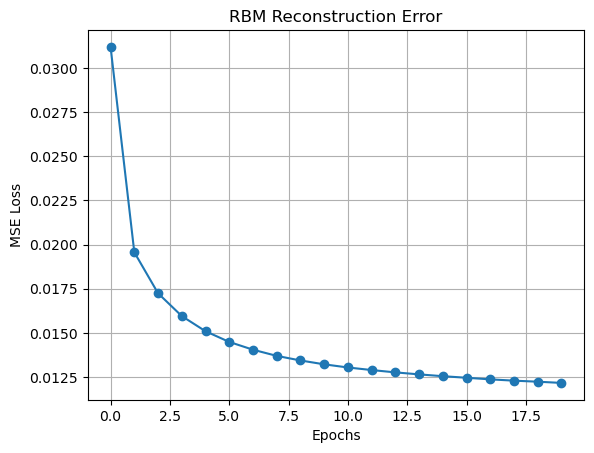

In [25]:
plt.plot(loss_curve, marker='o')
plt.title("RBM Reconstruction Error")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


Confirms learning progress

Lower reconstruction error → better feature learning

### Extract Hidden Features

In [27]:
subset = x_test[:5000]
hidden_features = rbm.hidden_rep(tf.convert_to_tensor(subset, dtype=tf.float32)).numpy()
labels = y_test[:5000]

print("Hidden feature shape:", hidden_features.shape)


Hidden feature shape: (5000, 128)


Output feature size = 5000 × 128

These are compressed representations learned by the RBM

### PCA Visualization in 2D

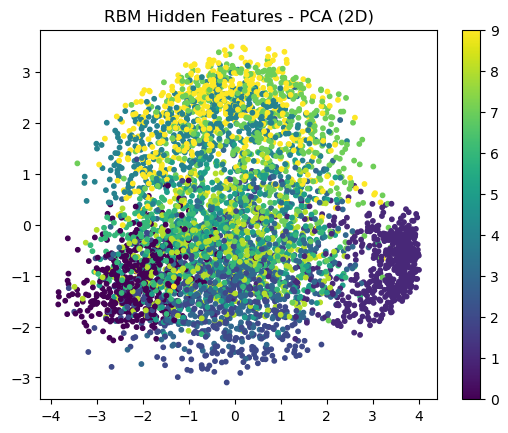

In [29]:
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(hidden_features)

plt.scatter(reduced_pca[:,0], reduced_pca[:,1], c=labels, s=10)
plt.title("RBM Hidden Features - PCA (2D)")
plt.colorbar()
plt.show()


Dimensionality reduced from 128 → 2

Different digits begin forming visible clusters

### t-SNE Visualization

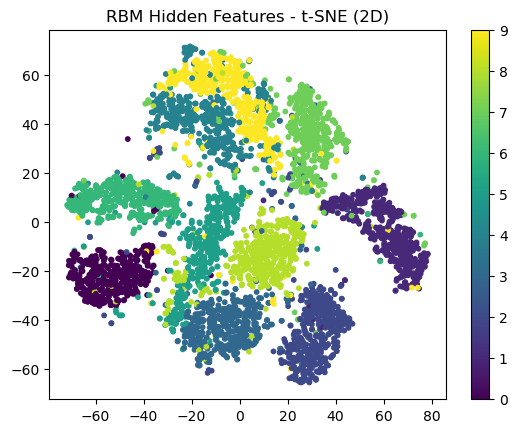

In [31]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_tsne = tsne.fit_transform(hidden_features)

plt.scatter(reduced_tsne[:,0], reduced_tsne[:,1], c=labels, s=10)
plt.title("RBM Hidden Features - t-SNE (2D)")
plt.colorbar()
plt.show()


 t-SNE provides clearer digit clusters

Shows that RBM successfully learned meaningful hidden structure

### Conclusion

The Restricted Boltzmann Machine (RBM) was trained using CD-1 on the MNIST dataset for 20 epochs.

The reconstruction Mean Squared Error (MSE) showed a strong downward trend from 0.031 → 0.012, indicating the model successfully learned to reconstruct input images.

After training, we extracted hidden layer activations (128 features) which serve as compressed representations of MNIST digits.